In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
import numpy as np
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/pse_isr_reddit_comments.csv')
df

,comment_id,score,self_text,subreddit,created_time
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00
...,...,...,...,...,...
436720,k3sdwfc,42,US. This is bullshit,Palestine,2023-10-06 23:50:11+00:00
436721,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-10-06 23:47:23+00:00
436722,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-10-06 23:38:26+00:00
436723,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-10-06 20:16:05+00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436725 entries, 0 to 436724
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    436725 non-null  object
 1   score         436725 non-null  int64 
 2   self_text     436725 non-null  object
 3   subreddit     436725 non-null  object
 4   created_time  436725 non-null  object
dtypes: int64(1), object(4)
memory usage: 16.7+ MB


In [5]:
df['self_text'] = df['self_text'] + ' and the confidence is ' + (df['score'] * 100).astype(str) + ' percent.'

In [6]:
for i in range(10):
    print(df.self_text[i])

Lol what kind of busted translator device you got. Does it speak only hasbara? and the confidence is 100 percent.
Translation:

Amen. Kill jews and continue gazan oppression! and the confidence is 100 percent.
Friendly fact reminder: Israel has been stealing Palestines land, bombing their civilians, controlling their access to water/food and kidnapping Palestinian civilians for over 50 years. Israel has  been committing genocide on Palestine but somehow people like you like to place the blame on Palestine. If you think Hamas is bad, I have some bad news about the IDF for you. and the confidence is 100 percent.
Well, i would never support Hamas, but there actions Israel could do that would make me stop supporting it: State orginized killing of Israeli or west bank Arabs or use of Atomic weaponary. and the confidence is 100 percent.
/u/TickeMeTendie. This is an automatic notice: 
'Nazis' Casual comments and analogies are inflammatory and therefor not allowed.  
We allow for exemptions fo

In [7]:
# Remove "@user"
df['clean_text'] = df.self_text.str.replace('@user', '')

# Replace non-alphanumeric characters with spaces
df['clean_text'] = df['clean_text'].str.replace("[^\w\s]", " ", regex=True)

# Remove "<br />"
df['clean_text'] = df['clean_text'].str.replace("<br />", " ")

# Remove mentions (@mentions)
df['clean_text'] = df['clean_text'].str.replace("@[A-Za-z0-9]+", " ", regex=True)

# Remove URLs
df['clean_text'] = df['clean_text'].str.replace("https?://[A-Za-z0-9./]+", " ", regex=True)

# Remove excess spaces
df['clean_text'] = df['clean_text'].str.replace(" +", " ", regex=True)

# Remove specific characters
df['clean_text'] = df['clean_text'].str.replace("[<>/;&]", " ", regex=True)

#Remove tabs
df['clean_text'] = df['clean_text'].str.replace("\n", " ")

In [8]:
df.head(5)

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,Lol what kind of busted translator device you ...
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,Translation Amen Kill jews and continue gaza...
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,Friendly fact reminder Israel has been stealin...
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,Well i would never support Hamas but there act...
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,u TickeMeTendie This is an automatic notice ...


In [9]:
#tokenization
df['clean_text'] = df['clean_text'].apply(lambda x: str(x) if type(x) != str else x)
df['clean_text'] = df['clean_text'].apply(lambda x: x.split())
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[Lol, what, kind, of, busted, translator, devi..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[Translation, Amen, Kill, jews, and, continue,..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[Friendly, fact, reminder, Israel, has, been, ..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[Well, i, would, never, support, Hamas, but, t..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[u, TickeMeTendie, This, is, an, automatic, no..."


In [10]:
#stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
df['clean_text']= df['clean_text'].apply(lambda x: [stemmer.stem(i) for i in x])
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[lol, what, kind, of, bust, translat, devic, y..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[translat, amen, kill, jew, and, continu, gaza..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[friend, fact, remind, israel, has, been, stea..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[well, i, would, never, support, hama, but, th..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[u, tickemetendi, this, is, an, automat, notic..."


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = nltk.corpus.stopwords.words('english')

In [13]:
newStopWords = ['u','go','got','via','or','ur','us','in','i','let','the','to','is','amp','make','one','day','days','get']
stopwords.extend(newStopWords)

In [14]:
import string
def process(text):
    # Check characters to see if they are in punctuation
    nopunc = set(char for char in list(text) if char not in string.punctuation)
    # Join the characters to form the string.
    nopunc = " ".join(nopunc)
    # remove any stopwords if present
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords]

In [15]:
df['clean_text'] = df['clean_text'].apply(process)
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,"[onli, translat, percent, 100, devic, confid, ..."
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,"[gazan, kill, continu, confid, jew, translat, ..."
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,"[fact, kidnap, blame, steal, access, civilian,..."
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,"[well, west, weaponari, israel, percent, isra,..."
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,"[detect, inform, moment, flag, com, use, infla..."


In [16]:
for i in range(10):
    print(df.clean_text[i])

['onli', 'translat', 'percent', '100', 'devic', 'confid', 'hasbara', 'doe', 'lol', 'bust', 'speak', 'kind']
['gazan', 'kill', 'continu', 'confid', 'jew', 'translat', 'percent', 'oppress', 'amen', '100']
['fact', 'kidnap', 'blame', 'steal', 'access', 'civilian', '50', 'bad', 'commit', 'water', 'israel', 'percent', 'peopl', '100', 'news', 'confid', 'idf', 'place', 'think', 'land', 'food', 'bomb', 'palestin', 'genocid', 'hama', 'year', 'friend', 'control', 'like', 'remind', 'palestinian', 'somehow']
['well', 'west', 'weaponari', 'israel', 'percent', 'isra', '100', 'support', 'would', 'use', 'confid', 'atom', 'could', 'action', 'kill', 'arab', 'state', 'hama', 'never', 'orgin', 'bank', 'stop']
['detect', 'inform', 'moment', 'flag', 'com', 'use', 'inflammatori', 'complianc', 'analog', '6', 'israelpalestin', 'comment', 'concern', 'review', 'cannot', 'www', 'moder', '_nazi_comparison', 'compos', 'messag', 'detail', 'bot', 'mainstream', 'accept', 'subreddit', 'unaccept', 'see', 'nazi', 'word',

VADER

In [17]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming df['clean_text'] is a list of strings
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

# Initialize the Sentiment Intensity Analyzer
analyzer = SentimentIntensityAnalyzer()

# Declare variables for scores
scores = {
    "Compound": [],
    "Positive": [],
    "Negative": [],
    "Neutral": []
}

# Generate sentiment scores for Reddit comments
for comment in df['clean_text']:
    compound = analyzer.polarity_scores(comment)["compound"]
    pos = analyzer.polarity_scores(comment)["pos"]
    neu = analyzer.polarity_scores(comment)["neu"]
    neg = analyzer.polarity_scores(comment)["neg"]

    scores["Compound"].append(compound)
    scores["Positive"].append(pos)
    scores["Negative"].append(neg)
    scores["Neutral"].append(neu)

# Create a new DataFrame for sentiment scores
sentiments_score = pd.DataFrame(scores)

# Join the sentiment scores DataFrame with the original DataFrame
df = pd.concat([df, sentiments_score], axis=1)

In [19]:
df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,onli translat percent 100 devic confid hasbara...,0.7351,0.383,0.000,0.617
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,gazan kill continu confid jew translat percent...,-0.6908,0.000,0.343,0.657
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,fact kidnap blame steal access civilian 50 bad...,-0.6597,0.175,0.272,0.553
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,well west weaponari israel percent isra 100 su...,-0.0031,0.228,0.160,0.612
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,detect inform moment flag com use inflammatori...,0.6908,0.121,0.000,0.879


In [20]:
# Define conditions for sentiment categories based on 'Compound' scores
# If Compound score is <= -0.5, classify as 'Negative'
# If Compound score is > -0.5 and < 0.5, classify as 'Neutral'
# If Compound score is >= 0.5, classify as 'Positive'
conditions = [
    (df['Compound'] <= -0.5),
    (df['Compound'] > -0.5) & (df['Compound'] < 0.5),
    (df['Compound'] > 0.5)
]

# Define corresponding values for each condition
values = ['Negative', 'Neutral', 'Positive']

# Create a new column 'Category' using np.select to assign values based on the conditions
df['Category'] = np.select(conditions, values)

df.head()

,comment_id,score,self_text,subreddit,created_time,clean_text,Compound,Positive,Negative,Neutral,Category
0,k70vrzb,1,Lol what kind of busted translator device you ...,IsraelPalestine,2023-10-29 23:59:03+00:00,onli translat percent 100 devic confid hasbara...,0.7351,0.383,0.000,0.617,Positive
1,k70vk4r,1,Translation:\n\nAmen. Kill jews and continue g...,IsraelPalestine,2023-10-29 23:57:29+00:00,gazan kill continu confid jew translat percent...,-0.6908,0.000,0.343,0.657,Negative
2,k70vhew,1,Friendly fact reminder: Israel has been steali...,IsraelPalestine,2023-10-29 23:56:58+00:00,fact kidnap blame steal access civilian 50 bad...,-0.6597,0.175,0.272,0.553,Negative
3,k70ve4h,1,"Well, i would never support Hamas, but there a...",IsraelPalestine,2023-10-29 23:56:18+00:00,well west weaponari israel percent isra 100 su...,-0.0031,0.228,0.160,0.612,Neutral
4,k70vay1,1,/u/TickeMeTendie. This is an automatic notice:...,IsraelPalestine,2023-10-29 23:55:42+00:00,detect inform moment flag com use inflammatori...,0.6908,0.121,0.000,0.879,Positive


In [21]:
# Group the DataFrame by 'Category' and count the occurrences of each category
category_counts = df.groupby(['Category'])['Category'].count()

# Create a DataFrame with counts and rename the column to 'Counts'
counts_df = pd.DataFrame(category_counts).rename(columns={"Category": "Counts"})

# Calculate the percentage for each category and add it as a new column 'Percentage'
counts_df['Percentage'] = (counts_df['Counts'] / counts_df['Counts'].sum()) * 100

counts_df = counts_df.drop(index='0')

# Print or return the summary DataFrame
print(counts_df)

          Counts  Percentage
Category                    
Negative  119933   27.461904
Neutral   265334   60.755395
Positive   51449   11.780640


In [22]:
import plotly.express as px

# Create a Pie Chart using Plotly
fig = px.pie(counts_df, values='Counts', names=counts_df.index,
             labels={'Category': 'Sentiment Category', 'Counts': 'Count'},
             title='Distribution of Sentiment Categories in Comments',
             hole=0.3,
             color_discrete_sequence=px.colors.qualitative.Set1)

# Set the background color of the Pie Chart to dark grey
fig.update_layout(paper_bgcolor='darkgrey')


# Show the Plotly Pie Chart
fig.show()

<ipython-input-23-9ebc3156a2cd>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


<ipython-input-23-9ebc3156a2cd>:10: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new 

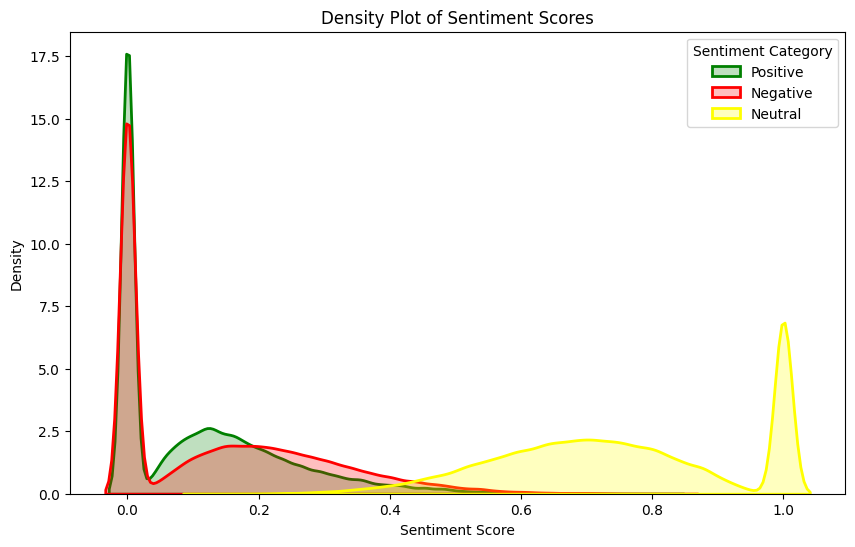

In [23]:
# Define the sentiment categories and corresponding colors
sentiment_categories = ["Positive", "Negative", "Neutral"]
colors = ['green', 'red', 'yellow']

# Set up the plot
plt.figure(figsize=(10, 6))

# Iterate over sentiment categories and plot KDE
for category, color in zip(sentiment_categories, colors):
    sns.distplot(df[category], hist=False, kde=True,
                 bins=int(180/5), color=color,
                 hist_kws={'edgecolor': 'black'},
                 kde_kws={'shade': True, 'linewidth': 2}, label=category)

# Set plot labels and legend
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Density Plot of Sentiment Scores')
plt.legend(title='Sentiment Category')

# Show the plot
plt.show()

<ipython-input-24-e5bd70c8c738>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




<Axes: xlabel='Compound', ylabel='Density'>

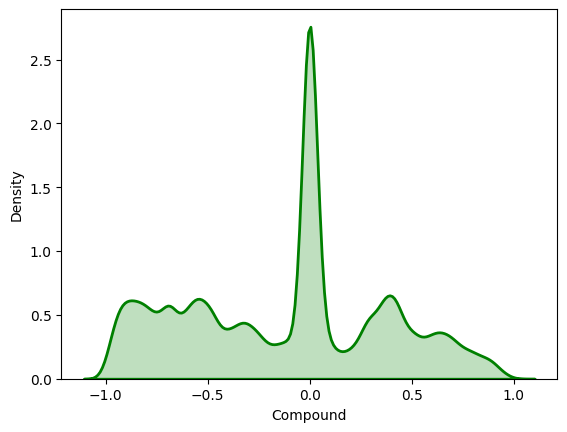

In [24]:
sns.distplot(df["Compound"], hist=False, kde=True,
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})

In [25]:
# Calculate the average sentiment scores for each subreddit
subreddit_sentiment = df.groupby('subreddit')[['Positive', 'Negative']].mean()

# Calculate the difference between positive and negative sentiment scores
subreddit_sentiment['Bias'] = subreddit_sentiment['Positive'] - subreddit_sentiment['Negative']

# Determine the direction of bias: Positive, Negative, or Neutral
def determine_bias_direction(bias):
    if bias > 0.01:  # You can adjust this threshold based on your dataset
        return 'Positive'
    elif bias < -0.01:  # You can adjust this threshold based on your dataset
        return 'Negative'
    else:
        return 'Neutral'

subreddit_sentiment['Bias Direction'] = subreddit_sentiment['Bias'].apply(determine_bias_direction)

# Sort subreddits based on bias in descending order
most_biased_subreddits = subreddit_sentiment.sort_values(by='Bias', ascending=False)

# Print or view the most biased subreddits with bias direction
print(most_biased_subreddits)

                       Positive  Negative      Bias Bias Direction
subreddit                                                         
AbruptChaos            0.113315  0.100550  0.012765       Positive
NonCredibleDefense     0.101943  0.109871 -0.007928        Neutral
Palestine              0.117255  0.135081 -0.017826       Negative
CrazyFuckingVideos     0.104336  0.124330 -0.019994       Negative
AskMiddleEast          0.112146  0.134870 -0.022724       Negative
IsraelPalestine        0.112638  0.139503 -0.026865       Negative
worldnews              0.109524  0.138966 -0.029443       Negative
CombatFootage          0.103754  0.140569 -0.036815       Negative
TerrifyingAsFuck       0.107101  0.148015 -0.040914       Negative
ActualPublicFreakouts  0.108045  0.152307 -0.044261       Negative
worldnewsvideo         0.105037  0.151303 -0.046266       Negative
PublicFreakout         0.103781  0.150333 -0.046552       Negative
IsrealPalestineWar_23  0.111454  0.170965 -0.059510       Nega

In [26]:
df.shape

(436725, 11)

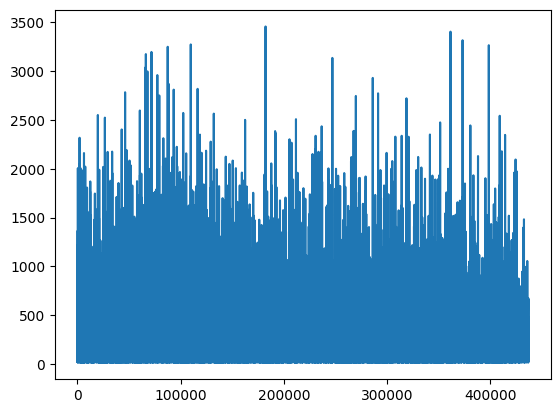

In [27]:
# Plotting word lenghts of comments
word_length = [len(x) for x in df['clean_text']]
plt.plot(word_length)

In [28]:
# Converting sentences to string
df['clean_text'] = df['clean_text'].astype(str)

In [29]:
# Assuming df is your DataFrame
df = df[df['Category'] != '0']

In [30]:
# Types of sentiments
df['Category'].value_counts()

Neutral     265334
Negative    119933
Positive     51449
Name: Category, dtype: int64

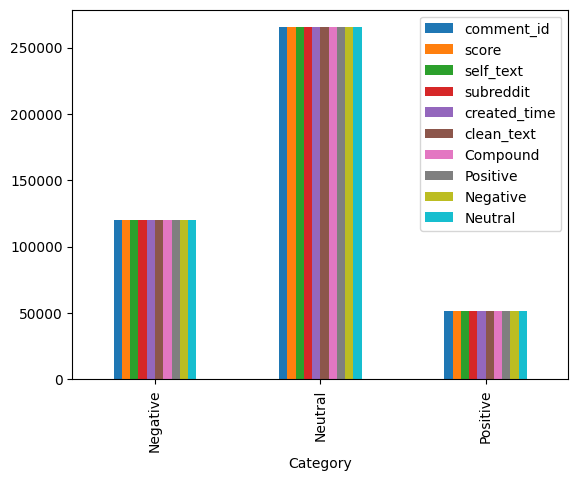

In [31]:
# Plotting sentiment value counts
df.groupby('Category').count().plot(kind='bar')
plt.show()

In [32]:
df = df[['clean_text', 'Category']]
df

,clean_text,Category
0,onli translat percent 100 devic confid hasbara...,Positive
1,gazan kill continu confid jew translat percent...,Negative
2,fact kidnap blame steal access civilian 50 bad...,Negative
3,well west weaponari israel percent isra 100 su...,Neutral
4,detect inform moment flag com use inflammatori...,Positive
...,...,...
436720,bullshit 4200 confid percent,Negative
436721,specif west percent gaza 100 confid say doe al...,Neutral
436722,countri map percent adapt frontier view confid...,Neutral
436723,onli percent support confid give cynic someth ...,Neutral


In [33]:
df['Category'].value_counts()

Neutral     265334
Negative    119933
Positive     51449
Name: Category, dtype: int64

Spitting Our Dataset into Training And Testing Dataset ( For Multiclass Classification)

In [34]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df,test_size = 0.2,random_state=0,stratify = df.Category.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("test shape : ", test.shape)

train shape :  (349372, 2)
test shape :  (87344, 2)


Use Of Counter Vectorizer For Multi Class Classification

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.clean_text.values)
X_test = vectorizer.transform(test.clean_text.values)

y_train = train.Category.values
y_test = test.Category.values

print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)
print("y_train.shape : ", y_train.shape)
print("y_test.shape : ", y_test.shape)

X_train.shape :  (349372, 93803)
X_test.shape :  (87344, 93803)
y_train.shape :  (349372,)
y_test.shape :  (87344,)


In [36]:
from numpy import percentile
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
#from gensim.models.doc2vec import LabeledSentence
import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Naive Bayes Classifier for MULTICLASS Classification

In [37]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_test)
NB_accuracy = accuracy_score(y_test,NB_prediction)
print("Training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Test accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_test))

Training accuracy Score    :  0.7612516171874105
Test accuracy Score :  0.7382991390364536
              precision    recall  f1-score   support

    Negative       0.65      0.71      0.68     21991
     Neutral       0.88      0.75      0.81     62367
    Positive       0.18      0.63      0.28      2986

    accuracy                           0.74     87344
   macro avg       0.57      0.70      0.59     87344
weighted avg       0.80      0.74      0.76     87344



In [38]:
# Define Naive Bayes classifier
naiveByes_clf = MultinomialNB()

# Perform cross-validation
cv_scores = cross_val_score(naiveByes_clf, X_train, y_train, cv=5)  # Use 5-fold cross-validation, you can adjust the number of folds as needed

# Print cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

# Now fit model on the entire training set
naiveByes_clf.fit(X_train, y_train)

# Predict on the test set
NB_prediction = naiveByes_clf.predict(X_test)

# Calculate accuracy on the test set
NB_accuracy = accuracy_score(y_test, NB_prediction)
print("Training accuracy Score:", naiveByes_clf.score(X_train, y_train))
print("Test accuracy Score:", NB_accuracy)
print(classification_report(NB_prediction, y_test))

Cross-Validation Scores: [0.73949195 0.73624329 0.73562412 0.73824312 0.73311962]
Mean CV Accuracy: 0.7365444207137376
Training accuracy Score: 0.7612516171874105
Test accuracy Score: 0.7382991390364536
              precision    recall  f1-score   support

    Negative       0.65      0.71      0.68     21991
     Neutral       0.88      0.75      0.81     62367
    Positive       0.18      0.63      0.28      2986

    accuracy                           0.74     87344
   macro avg       0.57      0.70      0.59     87344
weighted avg       0.80      0.74      0.76     87344



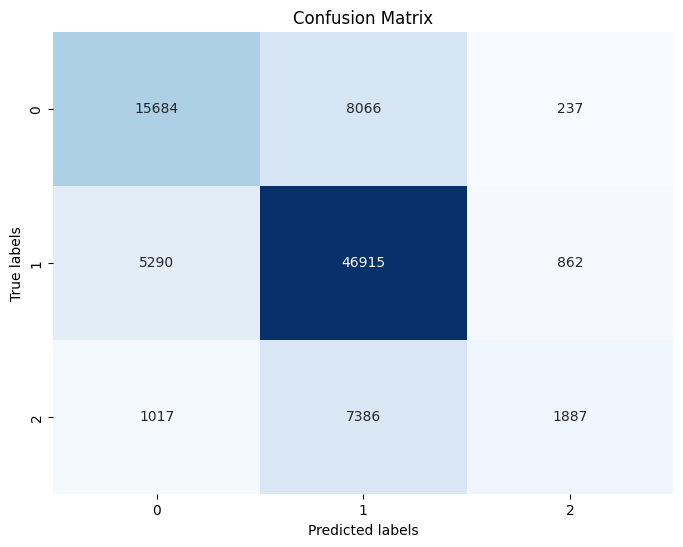

In [39]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, NB_prediction)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

Stochastic Gradient Descent-SGD Classifier( MULTICLASS CLASSIFICATION)

In [40]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Test accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))

Training accuracy Score    :  0.8677054829808915
Test accuracy Score :  0.8596354643707639
              precision    recall  f1-score   support

    Negative       0.90      0.85      0.87     25152
     Neutral       0.90      0.87      0.89     54837
    Positive       0.55      0.77      0.64      7355

    accuracy                           0.86     87344
   macro avg       0.78      0.83      0.80     87344
weighted avg       0.87      0.86      0.86     87344



In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Perform cross-validation
cv_predictions = cross_val_predict(sgd_clf, X_train, y_train, cv=5)  # Predictions for each fold

# Compute train accuracy
train_accuracy = accuracy_score(y_train, cv_predictions)
print("Training accuracy Score    : ", train_accuracy)

# Fit the model on the entire training data
sgd_clf.fit(X_train, y_train)

# Predict on the test set
sgd_prediction = sgd_clf.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, sgd_prediction)
print("Test accuracy Score : ", test_accuracy)

# Print classification report for test set
print("Classification Report for Test Set:")
print(classification_report(y_test, sgd_prediction))

# Print classification report for cross-validation predictions
print("Classification Report for Cross-Validation Predictions:")
print(classification_report(y_train, cv_predictions))


Training accuracy Score    :  0.8609562300356067
Test accuracy Score :  0.8596354643707639
Classification Report for Test Set:
              precision    recall  f1-score   support

    Negative       0.85      0.90      0.87     23987
     Neutral       0.87      0.90      0.89     53067
    Positive       0.77      0.55      0.64     10290

    accuracy                           0.86     87344
   macro avg       0.83      0.78      0.80     87344
weighted avg       0.86      0.86      0.86     87344

Classification Report for Cross-Validation Predictions:
              precision    recall  f1-score   support

    Negative       0.86      0.89      0.88     95946
     Neutral       0.87      0.91      0.89    212267
    Positive       0.78      0.54      0.64     41159

    accuracy                           0.86    349372
   macro avg       0.84      0.78      0.80    349372
weighted avg       0.86      0.86      0.86    349372



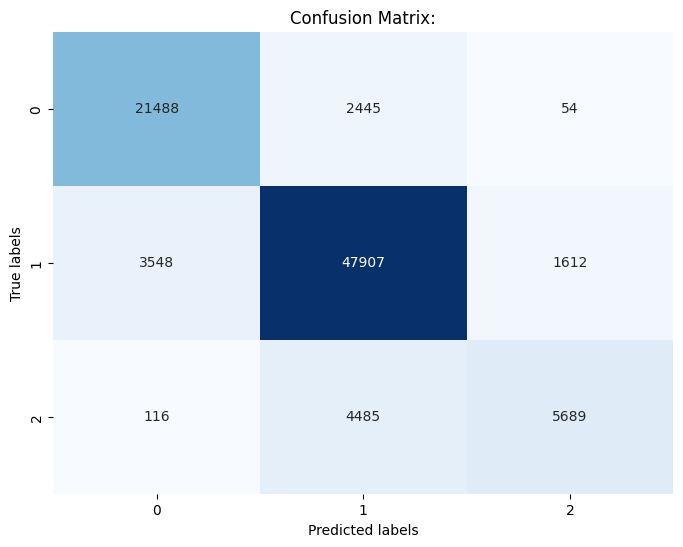

In [42]:
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, sgd_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

Logistic Regression(For Multiclass Classification)

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Test accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_test))

Training accuracy Score    :  0.9626930606917555
Test accuracy Score :  0.9455257373145265
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95     23638
     Neutral       0.97      0.95      0.96     54245
    Positive       0.85      0.92      0.88      9461

    accuracy                           0.95     87344
   macro avg       0.92      0.94      0.93     87344
weighted avg       0.95      0.95      0.95     87344



In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

# Assuming you have imported necessary libraries and have X_train, y_train ready

# Create the Logistic Regression model
logreg = LogisticRegression()

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Optionally, fit the model on the entire training data
logreg.fit(X_train, y_train)

# Make predictions on the test set
logreg_prediction = logreg.predict(X_test)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_prediction)
print("Training accuracy Score    : ", logreg.score(X_train, y_train))
print("Test accuracy Score : ", logreg_accuracy)
print(classification_report(logreg_prediction, y_test))


Cross-validation Scores: [0.94306977 0.9456458  0.94281135 0.94298308 0.94438561]
Mean CV Score: 0.9437791203722028
Training accuracy Score    :  0.9626930606917555
Test accuracy Score :  0.9455257373145265
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95     23638
     Neutral       0.97      0.95      0.96     54245
    Positive       0.85      0.92      0.88      9461

    accuracy                           0.95     87344
   macro avg       0.92      0.94      0.93     87344
weighted avg       0.95      0.95      0.95     87344



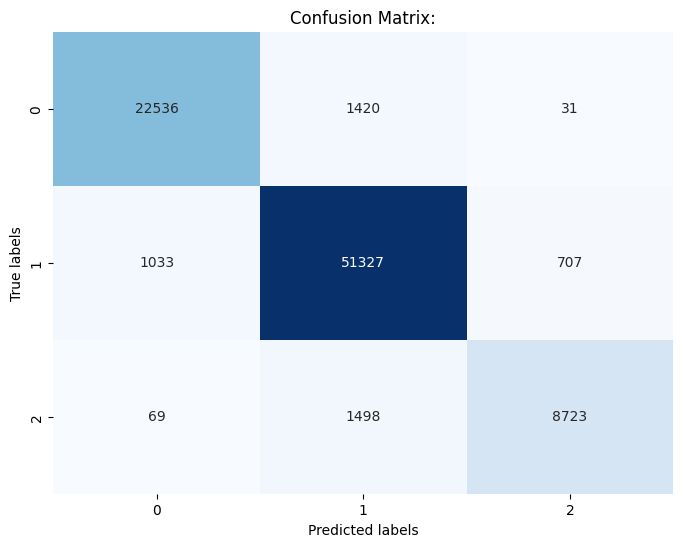

In [45]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, logreg_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

SVC

In [46]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Test accuracy Score : ",svc_acc )
print(classification_report(svc_pred,y_test))

Training accuracy Score    :  0.9491773811295696
Test accuracy Score :  0.9033705806924345
              precision    recall  f1-score   support

    Negative       0.91      0.92      0.92     23945
     Neutral       0.94      0.91      0.92     55054
    Positive       0.69      0.85      0.76      8345

    accuracy                           0.90     87344
   macro avg       0.85      0.89      0.87     87344
weighted avg       0.91      0.90      0.91     87344



In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import LinearSVC

# Create the SVC model
svc = LinearSVC(C=10, loss='hinge')

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(svc, X_train, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Fit the model on the entire training data
svc.fit(X_train, y_train)

# Make predictions on the test set
svc_prediction = svc.predict(X_test)

# Evaluate the model
svc_accuracy = accuracy_score(y_test, svc_prediction)
print("Training accuracy Score: ", svc.score(X_train, y_train))
print("Test accuracy Score: ", svc_accuracy)
print("Classification Report:")
print(classification_report(y_test, svc_prediction))


Cross-validation Scores: [0.91361717 0.91449016 0.91403097 0.913573   0.91235653]
Mean CV Score: 0.9136135669710205
Training accuracy Score:  0.9545098061664931
Test accuracy Score:  0.9169834218721378
Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.94      0.92     23987
     Neutral       0.93      0.93      0.93     53067
    Positive       0.85      0.78      0.81     10290

    accuracy                           0.92     87344
   macro avg       0.90      0.89      0.89     87344
weighted avg       0.92      0.92      0.92     87344



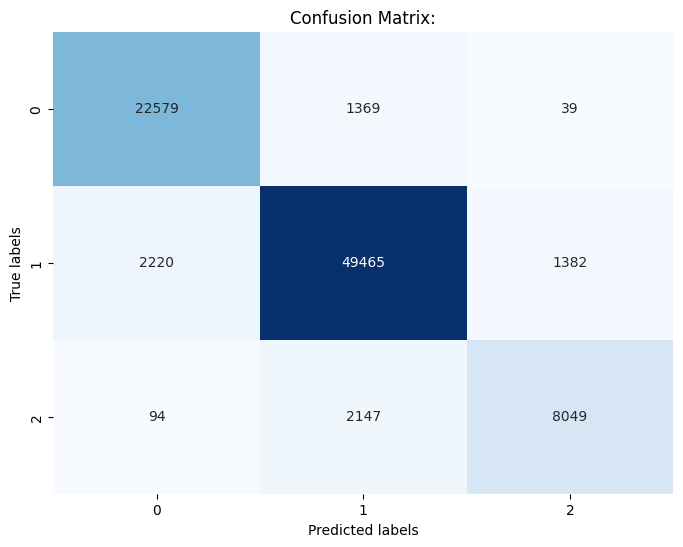

In [49]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, svc_prediction)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix:")
plt.show()

All the multiclass models test accuracy in descending order

In [50]:
models = pd.DataFrame({
    'Model': ['Logistic Regression',
              'Naive Bayes',
              'Stochastic Gradient Decent',
              'Support Vector'],
    'Test accuracy': [logreg_accuracy,
              NB_accuracy,
              sgd_accuracy,
              svc_acc]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
0,Logistic Regression,0.945526
3,Support Vector,0.903371
2,Stochastic Gradient Decent,0.859635
1,Naive Bayes,0.738299
